# XPCS Pipeline for SAXS
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [6]:
from chxanalys.chx_libs import (np, roi, time, datetime, os, get_events, 
                                getpass, db, get_images,LogNorm, plt,tqdm, utils, Model)

from chxanalys.chx_generic_functions import (get_detector, get_fields, get_sid_filenames,  
     load_data, load_mask,get_fields, reverse_updown, ring_edges,get_avg_img,check_shutter_open,
    apply_mask, show_img,check_ROI_intensity,run_time, plot1D, get_each_frame_intensity,                                             
    create_hot_pixel_mask,show_ROI_on_image,create_time_slice,save_lists, 
                        save_arrays, psave_obj,pload_obj, get_non_uniform_edges )
 

from chxanalys.XPCS_SAXS import (get_circular_average,save_lists,get_ring_mask, get_each_ring_mean_intensity,
                                 plot_qIq_with_ROI,save_saxs_g2,plot_saxs_g2,fit_saxs_g2,cal_g2,
                                create_hot_pixel_mask,get_circular_average,get_t_iq,save_saxs_g2,
                                plot_saxs_g2,fit_saxs_g2,fit_q2_rate,plot_saxs_two_g2,fit_q_rate,
                                circular_average,plot_saxs_g4, get_t_iqc,multi_uids_saxs_xpcs_analysis)


from chxanalys.Two_Time_Correlation_Function import (show_C12, get_one_time_from_two_time,
                                                get_four_time_from_two_time,rotate_g12q_to_rectangle)

from chxanalys.chx_compress_analysis import ( compress_eigerdata, read_compressed_eigerdata,
                                             Multifile,get_avg_imgc, get_each_frame_intensityc,
                get_each_ring_mean_intensityc, mean_intensityc,cal_waterfallc,plot_waterfallc)

from chxanalys.SAXS import fit_form_factor
from chxanalys.chx_correlationc import ( cal_g2c,Get_Pixel_Arrayc,auto_two_Arrayc,get_pixelist_interp_iq,)
from chxanalys.chx_correlationp import (cal_g2p, auto_two_Arrayp)

from chxanalys.Create_Report import (create_pdf_report, 
                                create_multi_pdf_reports_for_uids,create_one_pdf_reports_for_uids)


from chxanalys.XPCS_GiSAXS import (get_qedge,get_qmap_label,get_qr_tick_label, get_reflected_angles,
    convert_gisaxs_pixel_to_q, show_qzr_map, get_1d_qr, get_qzrmap, show_qzr_roi,get_each_box_mean_intensity,
    save_gisaxs_g2,plot_gisaxs_g2, fit_gisaxs_g2,plot_gisaxs_two_g2,plot_qr_1d_with_ROI,fit_qr_qz_rate,
                                  multi_uids_gisaxs_xpcs_analysis,plot_gisaxs_g4)

%matplotlib notebook

In [7]:
plt.rcParams.update({'figure.max_open_warning': 0})

In [8]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [9]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /user/yuzhang/analysis/2016_3/Dursch/XPCS_SAXS_Multi_Run_Nov-protein.ipynb


## Make a directory for saving results

In [10]:
CYCLE = '2016_3'
username = getpass.getuser()
#username = "commissioning"

username = "Dursch"

date_path = datetime.now().strftime('%Y/%m/%d')  # e.g., '2016/03/01'
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')

##Or define data_dir here, e.g.,#data_dir = '/XF11ID/analysis/2016_2/rheadric/test/'

os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/Dursch/Results/


## Load Metadata & Image Data

Print detector, scan-id, uid, datapath of data collected.

# Change these lines to get data

In [72]:
start_time, stop_time = '2016-11-3  15:59:00', '2016-11-3  16:05:00' 

#count : 1 ['8c9112'] (scan num: 126) (Measurement: PSPMMA1b 200C 50 x.002s 2s period_run_0_0 )

hdrs = db(start_time= start_time, stop_time = stop_time)
print ('Totally %s uids are found'%(len(hdrs)))
sids=[]
uids=[]

for hdr in hdrs:
    s= get_sid_filenames( hdr)
    print (s)
    sids.append( s[0] )
    uids.append( s[1] )
sids=sids[::-1]
uids=uids[::-1]

uid = uids[0]

Totally 8 uids are found
(4367, '5bae50ed-0881-4052-a845-0071f7d35907', ['/XF11ID/data/2016/11/03/70bef37f-de4e-4e77-92b9_765'])
(4366, 'a82de589-484b-4c39-b917-c2e926d8736a', ['/XF11ID/data/2016/11/03/03deced7-5a31-4b8c-a03c_764'])
(4365, '4690a7d2-9e2f-431b-97f7-f1e509ef4fcf', ['/XF11ID/data/2016/11/03/6147dfc4-9dc1-4ed1-98f5_763'])
(4364, '47b0a91a-e558-439c-8d20-1c01676e7bab', ['/XF11ID/data/2016/11/03/c2797f98-f78f-47a4-bcb5_762'])
(4363, '4a4770c8-5814-44a5-8c2c-c0f011c676da', ['/XF11ID/data/2016/11/03/c4599abd-19dc-40d7-bab9_761'])
(4362, 'e91391ad-8198-406f-8b69-140ef40d4f36', ['/XF11ID/data/2016/11/03/a490d56a-3c91-44be-866e_760'])
(4361, 'a2e606fa-22c0-4874-897c-90bd9df57778', ['/XF11ID/data/2016/11/03/cddb4dfc-8757-4e49-9399_759'])
(4360, 'c54b9ad8-1d3c-43a8-ae79-60faaac47b38', ['/XF11ID/data/2016/11/03/4d0f72ee-99d6-4e5d-a194_758'])


In [12]:
uids[4]

'47c7767a-a180-481e-8518-00133b51be32'

In [122]:
uid_=  'MKSAG_20-T=50C-Nov3-8scan' #give a meaningful folder name
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/%s/'%uid_)

os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_3/Dursch/Results/MKSAG_20-T=50C-Nov3-8scan/


In [123]:
data_dir_ = os.path.join( data_dir, 'Average/')
os.makedirs(data_dir_, exist_ok=True)
print ( data_dir_)

/XF11ID/analysis/2016_3/Dursch/Results/MKSAG_20-T=50C-Nov3-8scan/Average/


# Don't Change these lines below here

In [124]:
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

Detector is:  eiger4m_single_image
scan_id, full-uid, data path are:  4360--c54b9ad8-1d3c-43a8-ae79-60faaac47b38--/XF11ID/data/2016/11/03/4d0f72ee-99d6-4e5d-a194_758


In [125]:
imgs = load_data( uid, detector , reverse= True  )
Nimg = len(imgs)
md = imgs.md

hdf5 path = /XF11ID/data/2016/11/03/4d0f72ee-99d6-4e5d-a194_758_master.h5


In [126]:
try:
    md['Measurement']= db[uid]['start']['Measurement']
    md['sample']=db[uid]['start']['sample']     
    m#d['sample']= 'PS205000-PMMA-207000-SMMA3'
    print( md['sample'])
    
except:
    md['Measurement']= 'Measurement'
    md['sample']='sample'

In [127]:
imgs

Sliced and/or processed FixedEigerImages. Original repr:
    <Frames>
    Length: 500 frames
    Frame Shape: 2167 x 2070
    Pixel Datatype: uint16

## Overwrite Some Metadata Due to Wrong Input

In [128]:
md

{'Measurement': 'Measurement',
 'beam_center_x': 1477.0,
 'beam_center_y': 786.0,
 'count_time': 0.00133,
 'detector_distance': 4.8899999,
 'frame_time': 0.00134,
 'incident_wavelength': 1.2848103,
 'pixel_mask': array([[0, 0, 0, ..., 0, 0, 4],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint32),
 'sample': 'sample',
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [129]:
# The physical size of the pixels
dpix = md['x_pixel_size'] * 1000.  #in mm, eiger 4m is 0.075 mm
lambda_ =md['incident_wavelength']    # wavelegth of the X-rays in Angstroms

Ldet = 4.84 * 1000          # detector to sample distance (mm), currently, *1000 for saxs, *1 for gisaxs

exposuretime= md['count_time']
acquisition_period = md['frame_time']
print( 'The sample is %s'%(  md['sample']  ))
print( 'Exposuretime=%s sec, Acquisition_period=%s sec'%( exposuretime, acquisition_period  ))
timeperframe = acquisition_period#for g2
#timeperframe = exposuretime#for visiblitly

#timeperframe = 2  ## manual overwrite!!!! we apparently writing the wrong metadata....

center = [  md['beam_center_x'], md['beam_center_y']  ]   #for 4M
center=[center[1], center[0]]
print ('Beam center=', center)




The sample is sample
Exposuretime=0.00133 sec, Acquisition_period=0.00134 sec
Beam center= [786.0, 1477.0]


In [130]:
setup_pargs=dict(uid=uid_, dpix= dpix, Ldet=Ldet, lambda_= lambda_, 
        timeperframe=timeperframe, center=center, path= data_dir_, md=md)

In [131]:
setup_pargs

{'Ldet': 4840.0,
 'center': [786.0, 1477.0],
 'dpix': 0.075000003562308848,
 'lambda_': 1.2848103,
 'md': {'Measurement': 'Measurement',
  'beam_center_x': 1477.0,
  'beam_center_y': 786.0,
  'count_time': 0.00133,
  'detector_distance': 4.8899999,
  'frame_time': 0.00134,
  'incident_wavelength': 1.2848103,
  'pixel_mask': array([[0, 0, 0, ..., 0, 0, 4],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ..., 
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint32),
  'sample': 'sample',
  'x_pixel_size': 7.5000004e-05,
  'y_pixel_size': 7.5000004e-05},
 'path': '/XF11ID/analysis/2016_3/Dursch/Results/MKSAG_20-T=50C-Nov3-8scan/Average/',
 'timeperframe': 0.00134,
 'uid': 'MKSAG_20-T=50C-Nov3-8scan'}

## Apply Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change these lines

In [132]:

mask_path = '/XF11ID/analysis/2016_3/masks/'
mask_name = 'Nov3_4M_mask.npy'

<IPython.core.display.Javascript object>


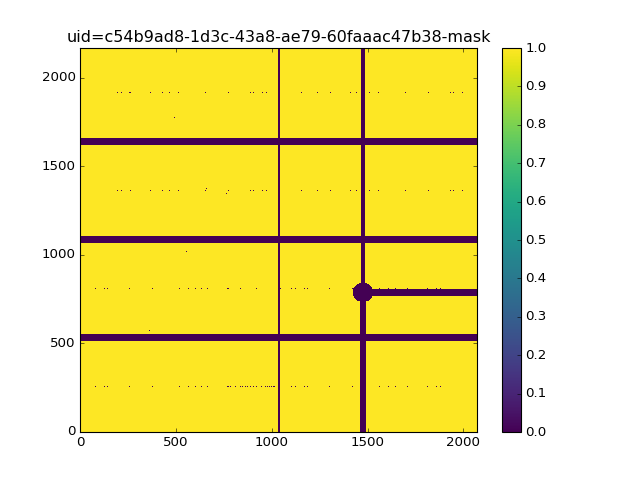

In [133]:
mask = load_mask(mask_path, mask_name, plot_ =  True, reverse=True, image_name = 'uid=%s-mask'%uid )

# Save metadata into the uid folder
* save mask file
* save the metadata dict

In [134]:
md['mask'] = mask
md['mask_file']= mask_path + mask_name 
md['NOTEBOOK_FULL_PATH'] = NOTEBOOK_FULL_PATH
#psave_obj(  md, data_dir + 'uid=%s-md'%uid ) #save the setup parameters
#md = pload_obj(data_dir + 'uid=%s-md'%uid  )

In [135]:
imgsa = apply_mask( imgs, mask )

<IPython.core.display.Javascript object>


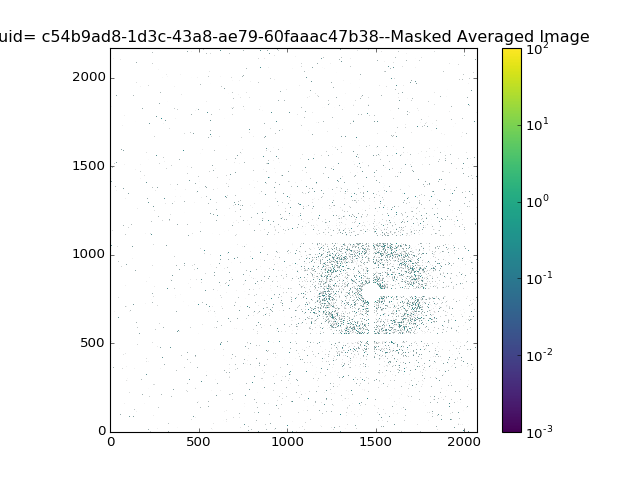

In [136]:
avg_img =  get_avg_img( imgsa, sampling = int(Nimg/3), plot_ = True, uid =uid)

<IPython.core.display.Javascript object>


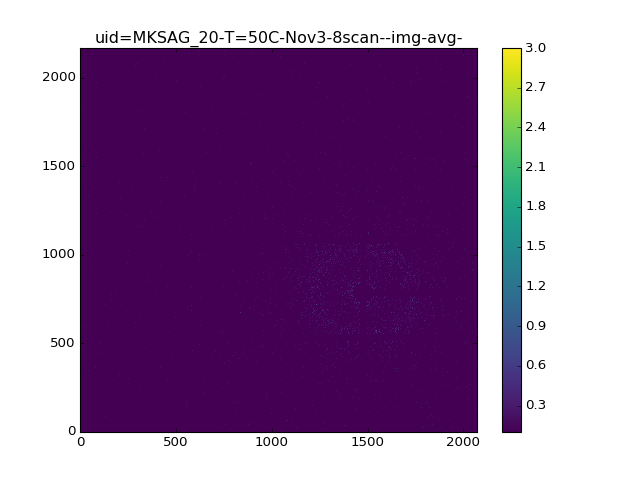

In [137]:
#avg_img = get_avg_imgc( FD,  beg=0,end=10000,sampling = 1, plot_ = False )
show_img( avg_img,  vmin=.1, vmax=3.0, logs=False, image_name= 'uid=%s--img-avg-'%uid_,
        save=True, path=data_dir_) 
md['avg_img'] = avg_img

# Suppose we have all the parameters to define ROIs, if not use the "Single_Data" Pipeline

### Get circular average 
* Do plot and save q~iq


<IPython.core.display.Javascript object>


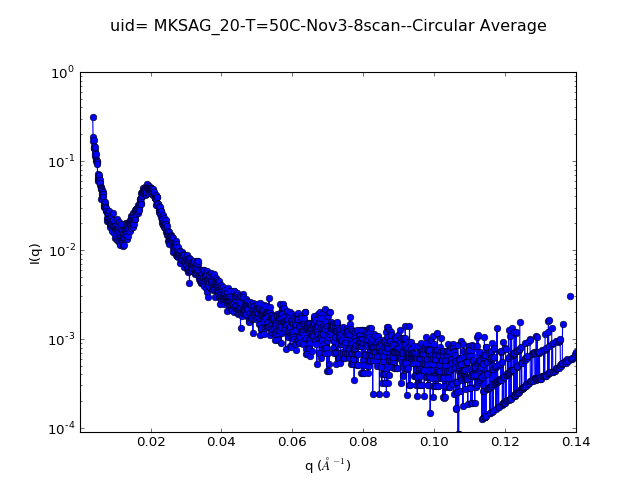

In [138]:
hmask = create_hot_pixel_mask( avg_img, 2**15 )
mask = mask * hmask
hmask = create_hot_pixel_mask( avg_img, 1e8)
qp, iq, q = get_circular_average( avg_img, mask * hmask, pargs=setup_pargs, nx=None,
            plot_ = True, show_pixel= False, xlim=[0.0001,.14], ylim = [0.00009, 1e0], save=True)



### Define ROI
* Create ring mask defined by  inner_radius, outer_radius, width, num_rings (all in pixel unit)
* Create ring mask defined by  edges (all in pixel unit)

In [139]:
uniform = True

### Define a non-uniform distributed rings by giving edges

In [140]:
if not uniform:
    #width = 4  # in pixel
    width = 0.001    
    number_rings=1
    #centers = [ 31, 50, 67, 84, 102, 119] #in pixel
    centers = [ 0.00235,0.00379,0.00508,0.00636,0.00773, 0.00902] #in A-1
    centers = [ 0.0065,0.0117,0.021,0.0336,0.044, 0.057] #in A-1
    edges = get_non_uniform_edges(  centers, width, number_rings )
    
    inner_radius= None
    outer_radius = None
    width = None
    num_rings = None

### Define a uniform distributed rings by giving inner_radius, outer_radius, width, num_rings (all in pixel unit)

In [141]:
if uniform:
    inner_radius= 0.0115
    outer_radius = 0.069
    width = 0.0035
    num_rings = 10
    edges = None

In [142]:
ring_mask, q_ring_center, q_ring_val = get_ring_mask(  mask, inner_radius=inner_radius, unit='A',
        outer_radius = outer_radius , width = width, num_rings = num_rings, edges=edges, pargs=setup_pargs   )
qind, pixelist = roi.extract_label_indices(  ring_mask  ) 

In [143]:
md['center'] = center
md['ring_mask'] = ring_mask
md['q_ring_center']= q_ring_center
md['q_ring_val'] = q_ring_val
md['beam_center_x'] =  center[1]
md['beam_center_y']=  center[0]
md['data_dir'] = data_dir

psave_obj(  md, data_dir_ + 'uid=%s-md'%uid_ ) #save the setup parameters

In [144]:
#pload_obj(   data_dir + 'uid=%s-md'%uid_  )

<IPython.core.display.Javascript object>


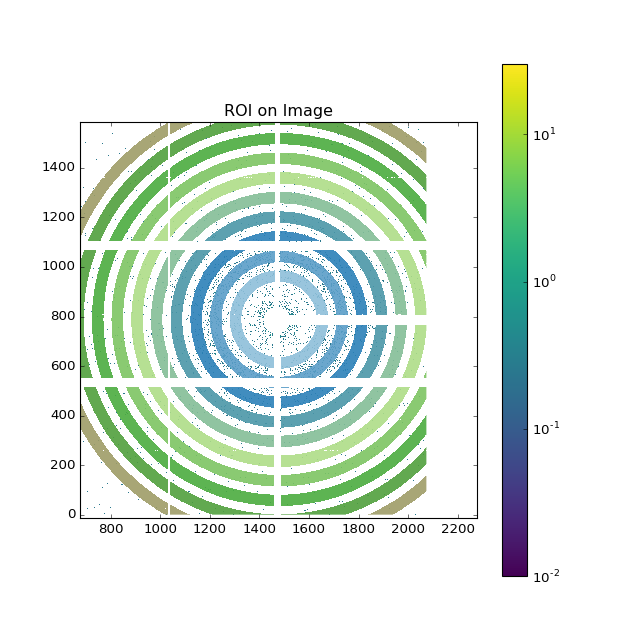

In [186]:
show_ROI_on_image( avg_img, ring_mask, center, label_on = False, rwidth=800, alpha=.9, 
                  vmax=30, save=True, path=data_dir_, uid=uid_)

<IPython.core.display.Javascript object>


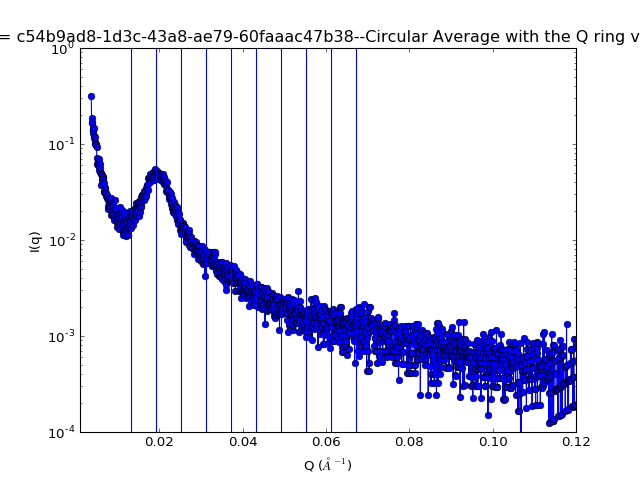

In [146]:
plot_qIq_with_ROI( q, iq, q_ring_center, logs=True, uid=uid, xlim=[0.001,.12],
                  ylim = [1e-4, 1e0],        save=True, path=data_dir)

# Do loop here

In [147]:
run_num = 1
sub_num =  len(uids) //run_num

In [148]:
data_dir

'/XF11ID/analysis/2016_3/Dursch/Results/MKSAG_20-T=50C-Nov3-8scan/'

Averaging images:  13%|█▎        | 66/500 [00:00<00:00, 657.14it/s]

The 0--th uid to be analyzed is : c54b9ad8-1d3c-43a8-ae79-60faaac47b38
hdf5 path = /XF11ID/data/2016/11/03/4d0f72ee-99d6-4e5d-a194_758_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_c54b9ad8-1d3c-43a8-ae79-60faaac47b38.cmp.


Get each frame intensity: 100%|██████████| 500/500 [00:00<00:00, 2939.71it/s]


No bad frames are involved.
XPCS T=50C, 500 fr 750Hz_run_0
With compression, the good_start frame number is: 10 
In this g2 calculation, the buf and lev number are: 8--8--
490 frames will be processed...


100%|██████████| 490/490 [01:30<00:00,  5.21it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/Dursch/Results/MKSAG_20-T=50C-Nov3-8scan/c54b9ad8-1d3c-43a8-ae79-60faaac47b38/ with filename as uid=c54b9ad8-1d3c-43a8-ae79-60faaac47b38--g2.csv


<IPython.core.display.Javascript object>


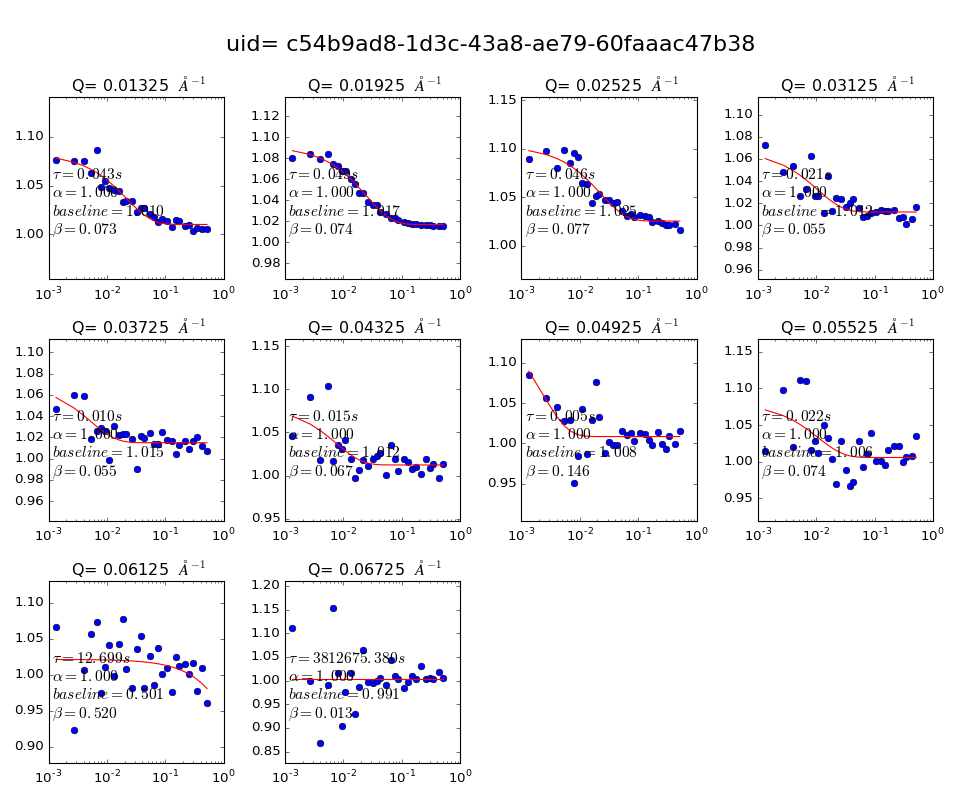

The fitted diffusion coefficient D0 is:  1.769e+04   A^2S-1


<IPython.core.display.Javascript object>


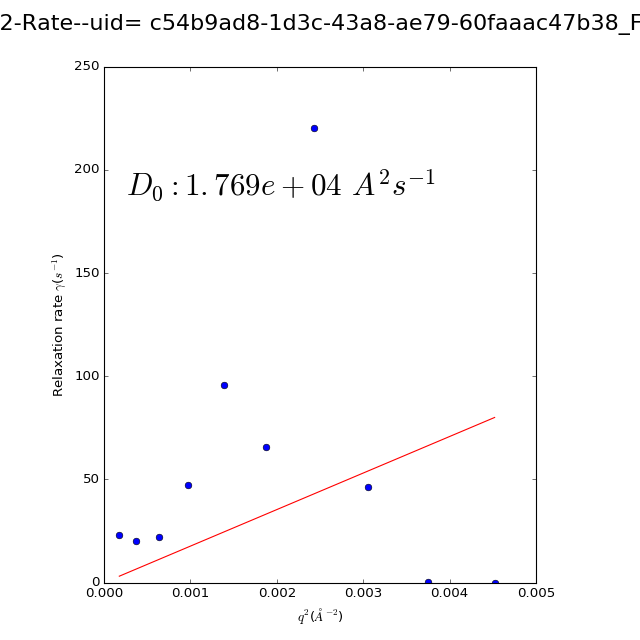

Averaging images:  31%|███▏      | 157/500 [00:00<00:00, 1568.83it/s]

****************************************

The 1--th uid to be analyzed is : a2e606fa-22c0-4874-897c-90bd9df57778
hdf5 path = /XF11ID/data/2016/11/03/cddb4dfc-8757-4e49-9399_759_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_a2e606fa-22c0-4874-897c-90bd9df57778.cmp.


Get each frame intensity: 100%|██████████| 500/500 [00:00<00:00, 5237.88it/s]


No bad frames are involved.
XPCS T=50C, 500 fr 750Hz_run_1
With compression, the good_start frame number is: 10 
In this g2 calculation, the buf and lev number are: 8--8--
490 frames will be processed...


100%|██████████| 490/490 [01:32<00:00,  5.35it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/Dursch/Results/MKSAG_20-T=50C-Nov3-8scan/a2e606fa-22c0-4874-897c-90bd9df57778/ with filename as uid=a2e606fa-22c0-4874-897c-90bd9df57778--g2.csv


<IPython.core.display.Javascript object>


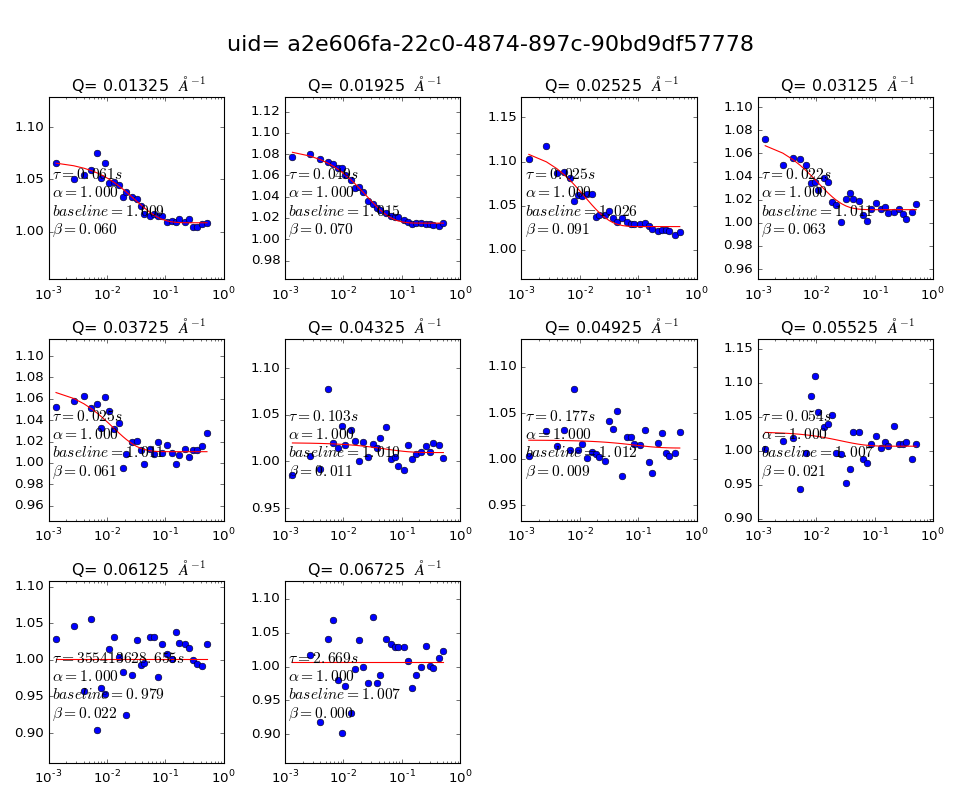

The fitted diffusion coefficient D0 is:  3.991e+03   A^2S-1


<IPython.core.display.Javascript object>


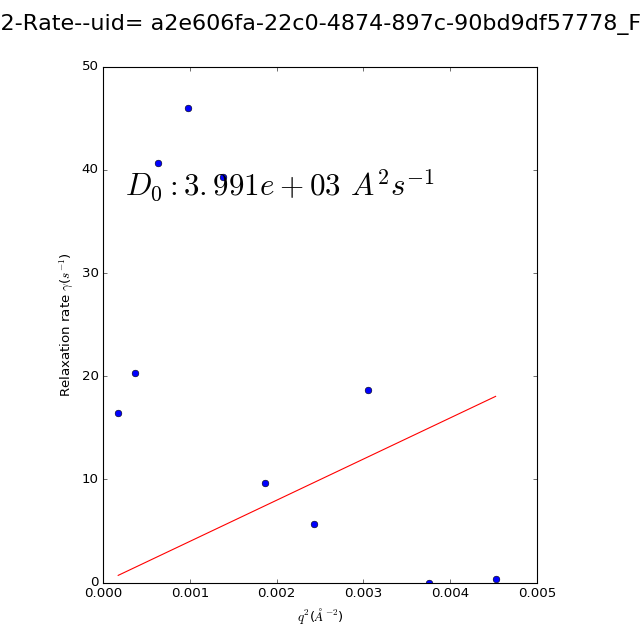

Averaging images:  36%|███▌      | 178/500 [00:00<00:00, 1772.40it/s]

****************************************

The 2--th uid to be analyzed is : e91391ad-8198-406f-8b69-140ef40d4f36
hdf5 path = /XF11ID/data/2016/11/03/a490d56a-3c91-44be-866e_760_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_e91391ad-8198-406f-8b69-140ef40d4f36.cmp.


Get each frame intensity: 100%|██████████| 500/500 [00:00<00:00, 4905.26it/s]


Bad frame list length is: 1
XPCS T=50C, 500 fr 750Hz_run_2
With compression, the good_start frame number is: 10 
In this g2 calculation, the buf and lev number are: 8--8--
Bad frame involved and will be precessed!
490 frames will be processed...


100%|██████████| 490/490 [01:31<00:00,  4.78it/s]

G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/Dursch/Results/MKSAG_20-T=50C-Nov3-8scan/e91391ad-8198-406f-8b69-140ef40d4f36/ with filename as uid=e91391ad-8198-406f-8b69-140ef40d4f36--g2.csv


<IPython.core.display.Javascript object>


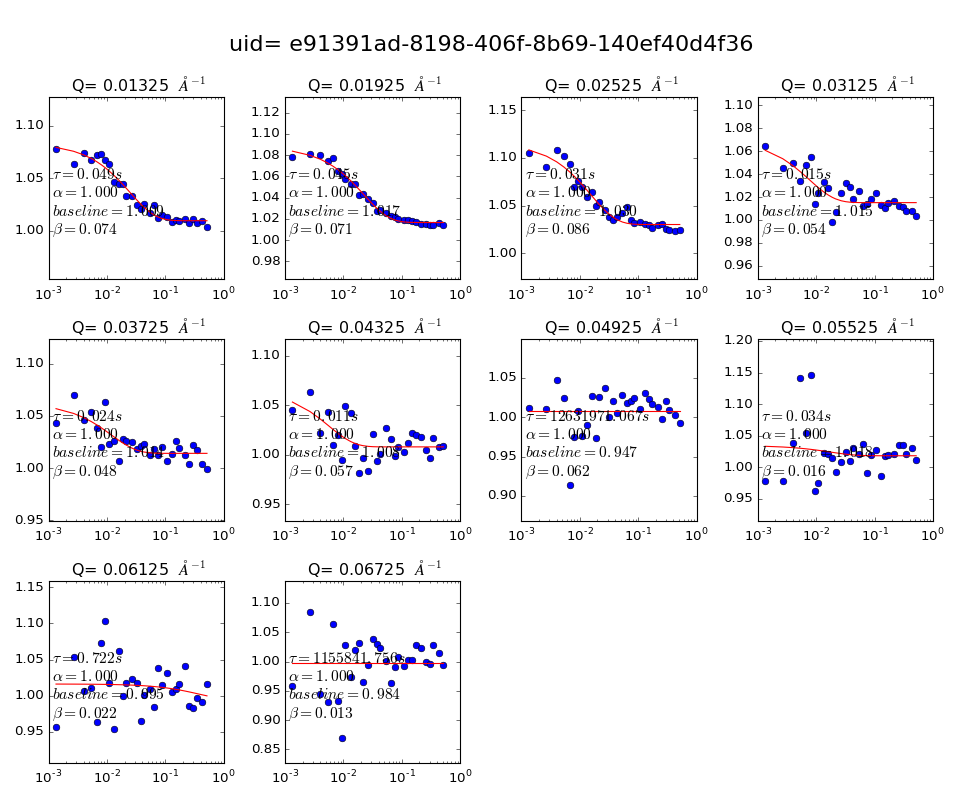

The fitted diffusion coefficient D0 is:  7.323e+03   A^2S-1


<IPython.core.display.Javascript object>


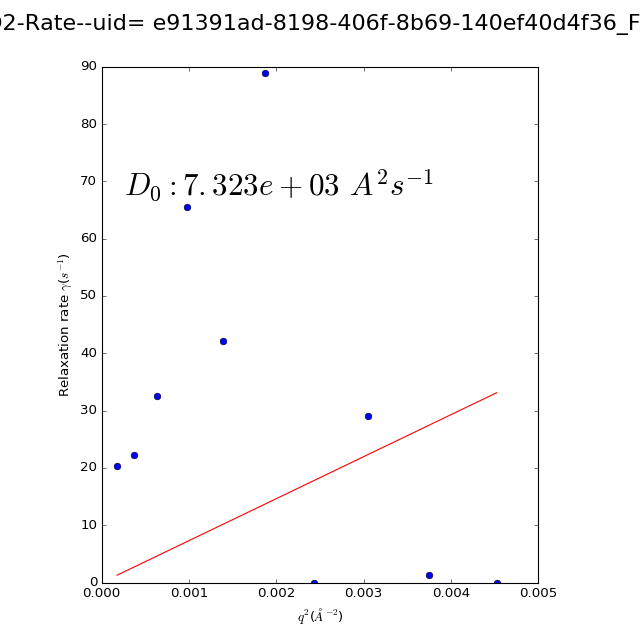

Averaging images:  26%|██▌       | 131/500 [00:00<00:00, 1304.50it/s]

****************************************

The 3--th uid to be analyzed is : 4a4770c8-5814-44a5-8c2c-c0f011c676da
hdf5 path = /XF11ID/data/2016/11/03/c4599abd-19dc-40d7-bab9_761_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_4a4770c8-5814-44a5-8c2c-c0f011c676da.cmp.


Get each frame intensity: 100%|██████████| 500/500 [00:00<00:00, 5375.40it/s]


No bad frames are involved.
XPCS T=50C, 500 fr 750Hz_run_3
With compression, the good_start frame number is: 10 
In this g2 calculation, the buf and lev number are: 8--8--
490 frames will be processed...


100%|██████████| 490/490 [01:32<00:00,  5.19it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/Dursch/Results/MKSAG_20-T=50C-Nov3-8scan/4a4770c8-5814-44a5-8c2c-c0f011c676da/ with filename as uid=4a4770c8-5814-44a5-8c2c-c0f011c676da--g2.csv


<IPython.core.display.Javascript object>


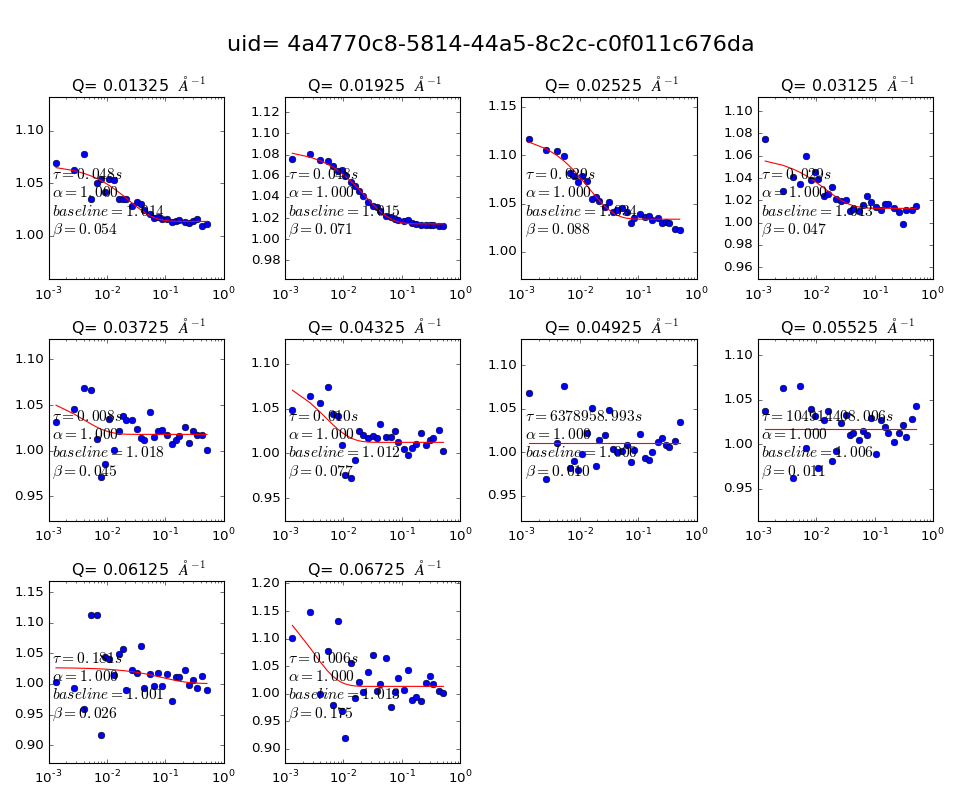

The fitted diffusion coefficient D0 is:  2.176e+04   A^2S-1


<IPython.core.display.Javascript object>


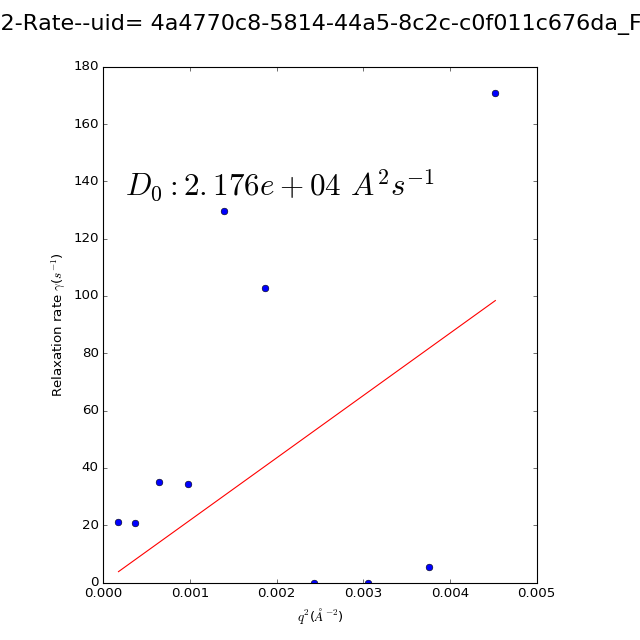

Averaging images:  29%|██▉       | 144/500 [00:00<00:00, 1433.21it/s]

****************************************

The 4--th uid to be analyzed is : 47b0a91a-e558-439c-8d20-1c01676e7bab
hdf5 path = /XF11ID/data/2016/11/03/c2797f98-f78f-47a4-bcb5_762_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_47b0a91a-e558-439c-8d20-1c01676e7bab.cmp.


Get each frame intensity: 100%|██████████| 500/500 [00:00<00:00, 5548.02it/s]


No bad frames are involved.
XPCS T=50C, 500 fr 750Hz_run_4
With compression, the good_start frame number is: 10 
In this g2 calculation, the buf and lev number are: 8--8--
490 frames will be processed...


100%|██████████| 490/490 [01:33<00:00,  5.18it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/Dursch/Results/MKSAG_20-T=50C-Nov3-8scan/47b0a91a-e558-439c-8d20-1c01676e7bab/ with filename as uid=47b0a91a-e558-439c-8d20-1c01676e7bab--g2.csv


<IPython.core.display.Javascript object>


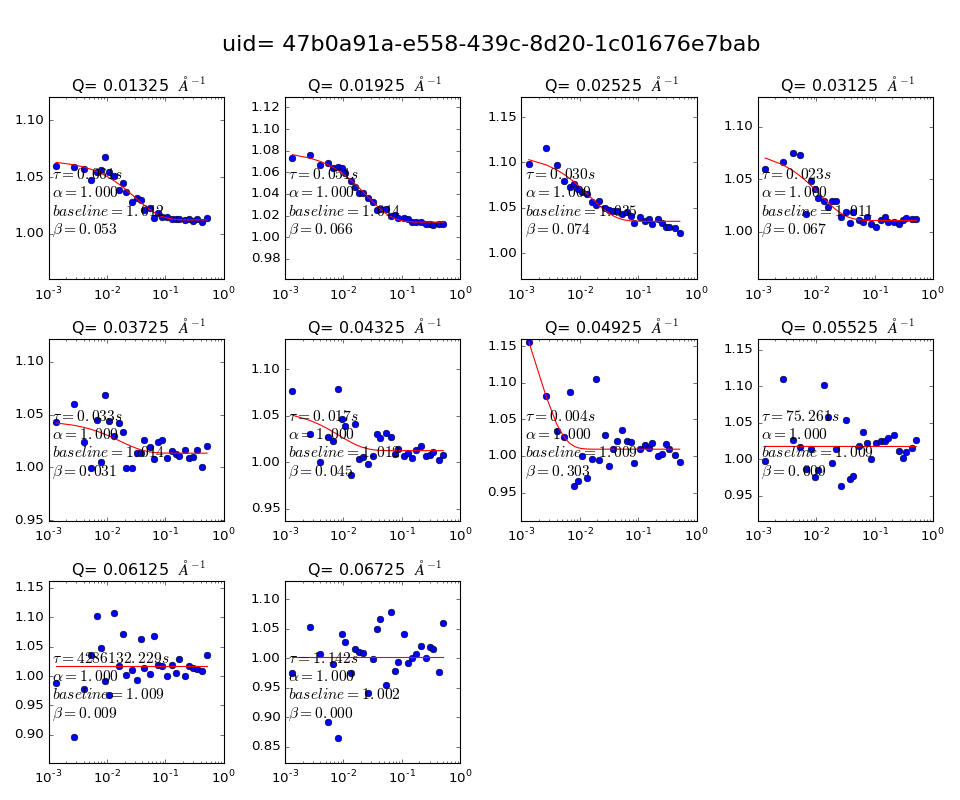

The fitted diffusion coefficient D0 is:  1.565e+04   A^2S-1


<IPython.core.display.Javascript object>


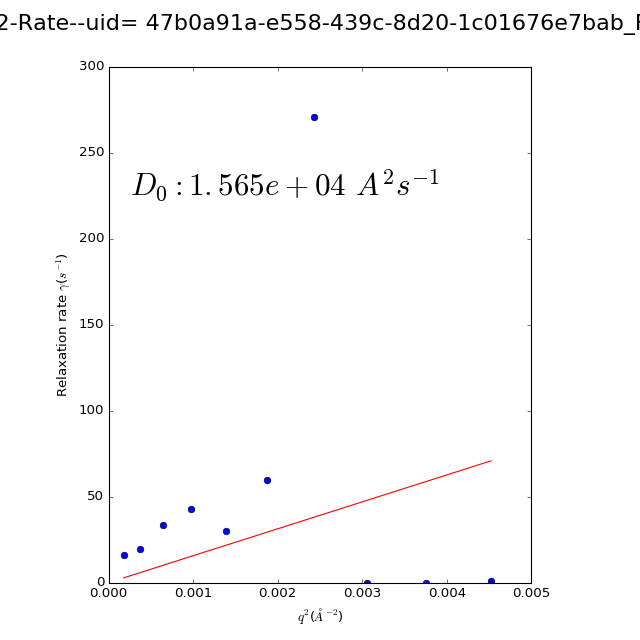

Averaging images:  32%|███▏      | 159/500 [00:00<00:00, 1585.96it/s]

****************************************

The 5--th uid to be analyzed is : 4690a7d2-9e2f-431b-97f7-f1e509ef4fcf
hdf5 path = /XF11ID/data/2016/11/03/6147dfc4-9dc1-4ed1-98f5_763_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_4690a7d2-9e2f-431b-97f7-f1e509ef4fcf.cmp.


Get each frame intensity: 100%|██████████| 500/500 [00:00<00:00, 2945.40it/s]


No bad frames are involved.
XPCS T=50C, 500 fr 750Hz_run_5
With compression, the good_start frame number is: 10 
In this g2 calculation, the buf and lev number are: 8--8--
490 frames will be processed...


100%|██████████| 490/490 [01:33<00:00,  5.35it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/Dursch/Results/MKSAG_20-T=50C-Nov3-8scan/4690a7d2-9e2f-431b-97f7-f1e509ef4fcf/ with filename as uid=4690a7d2-9e2f-431b-97f7-f1e509ef4fcf--g2.csv


<IPython.core.display.Javascript object>


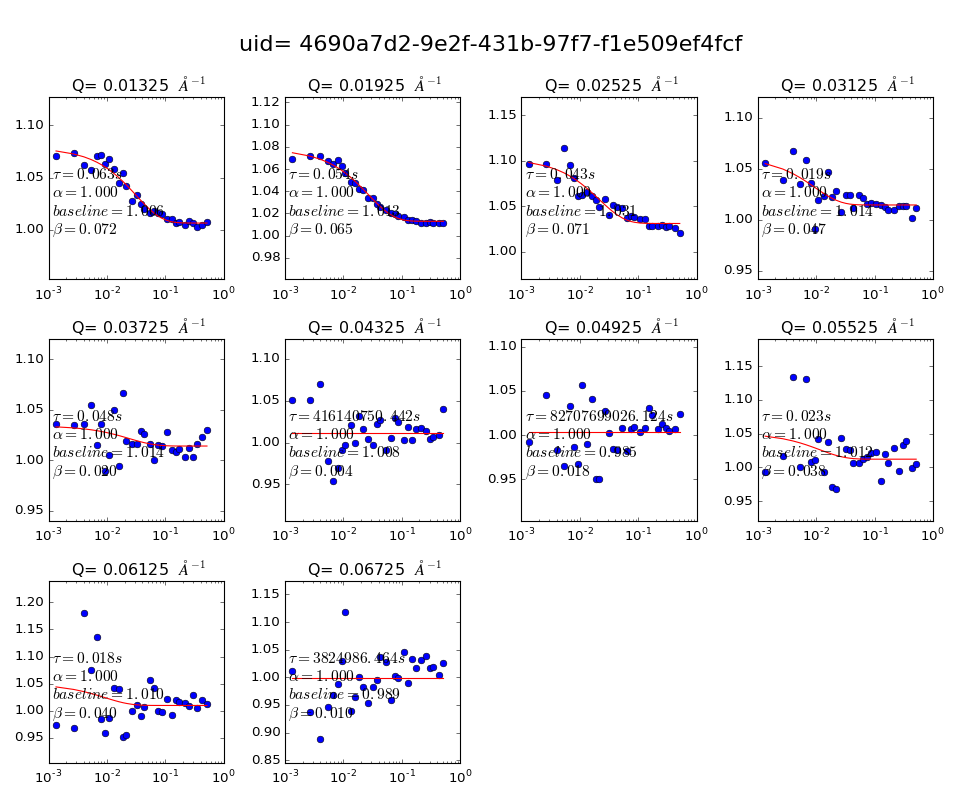

The fitted diffusion coefficient D0 is:  7.819e+03   A^2S-1


<IPython.core.display.Javascript object>


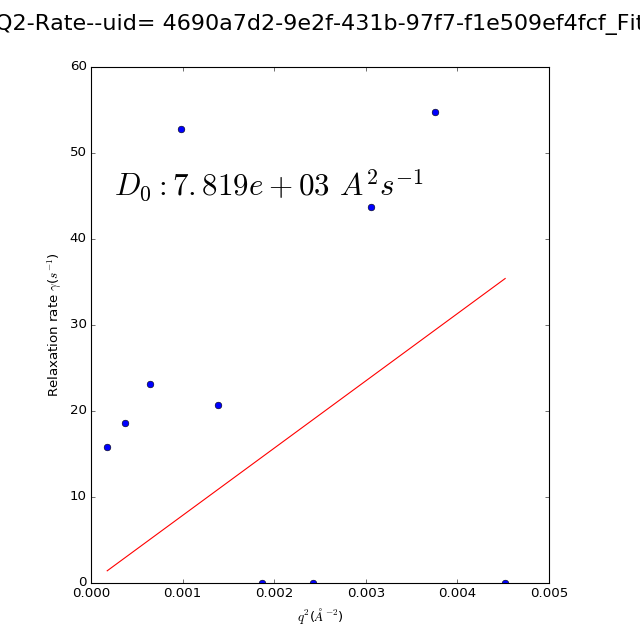

Averaging images:  31%|███       | 156/500 [00:00<00:00, 1559.15it/s]

****************************************

The 6--th uid to be analyzed is : a82de589-484b-4c39-b917-c2e926d8736a
hdf5 path = /XF11ID/data/2016/11/03/03deced7-5a31-4b8c-a03c_764_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_a82de589-484b-4c39-b917-c2e926d8736a.cmp.


Get each frame intensity: 100%|██████████| 500/500 [00:00<00:00, 5089.46it/s]


No bad frames are involved.
XPCS T=50C, 500 fr 750Hz_run_6
With compression, the good_start frame number is: 10 
In this g2 calculation, the buf and lev number are: 8--8--
490 frames will be processed...


100%|██████████| 490/490 [01:32<00:00,  5.13it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/Dursch/Results/MKSAG_20-T=50C-Nov3-8scan/a82de589-484b-4c39-b917-c2e926d8736a/ with filename as uid=a82de589-484b-4c39-b917-c2e926d8736a--g2.csv


<IPython.core.display.Javascript object>


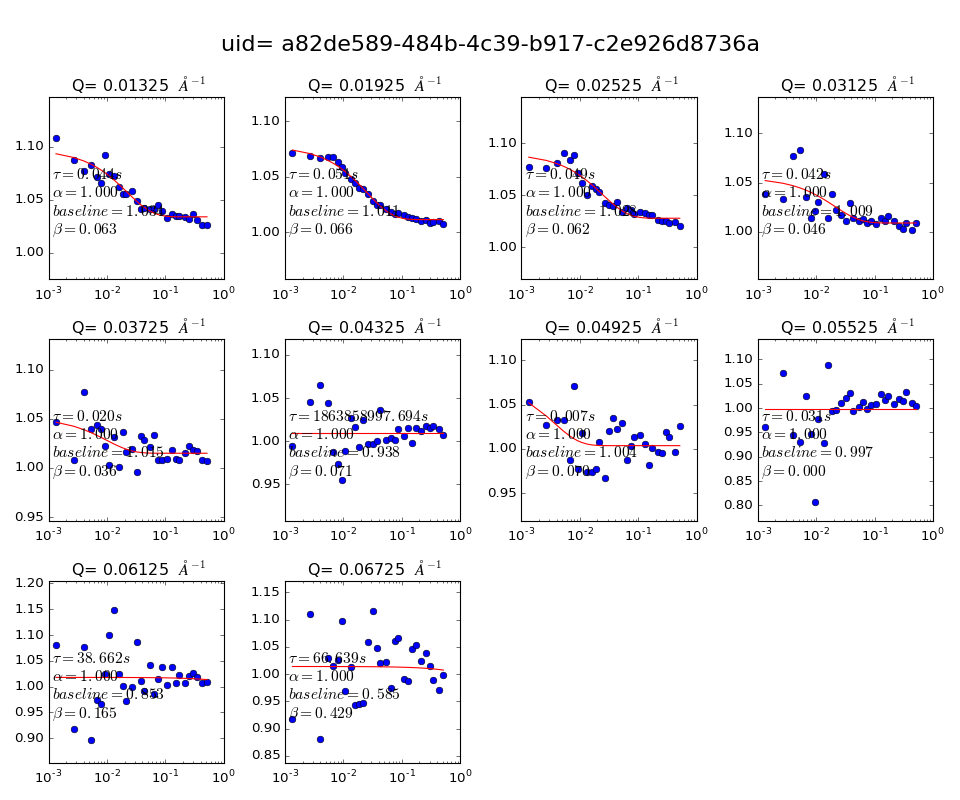

The fitted diffusion coefficient D0 is:  9.753e+03   A^2S-1


<IPython.core.display.Javascript object>


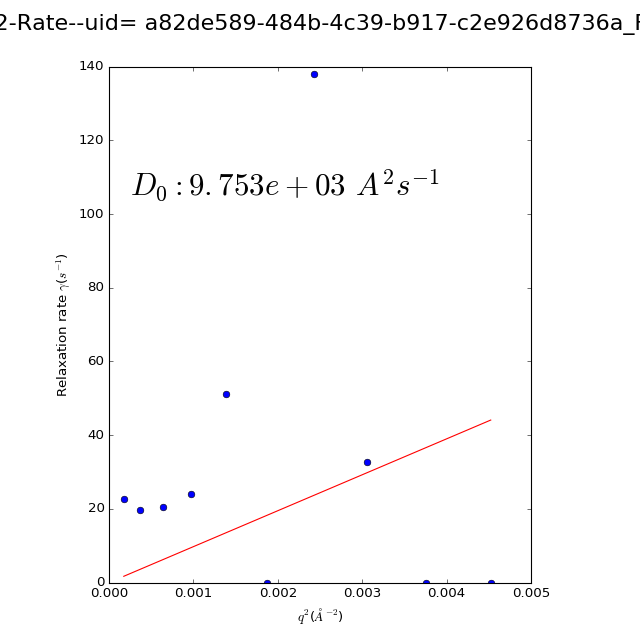

Averaging images:  32%|███▏      | 161/500 [00:00<00:00, 1608.62it/s]

****************************************

The 7--th uid to be analyzed is : 5bae50ed-0881-4052-a845-0071f7d35907
hdf5 path = /XF11ID/data/2016/11/03/70bef37f-de4e-4e77-92b9_765_master.h5
Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_5bae50ed-0881-4052-a845-0071f7d35907.cmp.


Get each frame intensity: 100%|██████████| 500/500 [00:00<00:00, 5405.60it/s]


No bad frames are involved.
XPCS T=50C, 500 fr 750Hz_run_7
With compression, the good_start frame number is: 10 
In this g2 calculation, the buf and lev number are: 8--8--
490 frames will be processed...


100%|██████████| 490/490 [01:33<00:00,  5.33it/s]


G2 calculation DONE!
The correlation function is saved in /XF11ID/analysis/2016_3/Dursch/Results/MKSAG_20-T=50C-Nov3-8scan/5bae50ed-0881-4052-a845-0071f7d35907/ with filename as uid=5bae50ed-0881-4052-a845-0071f7d35907--g2.csv


<IPython.core.display.Javascript object>


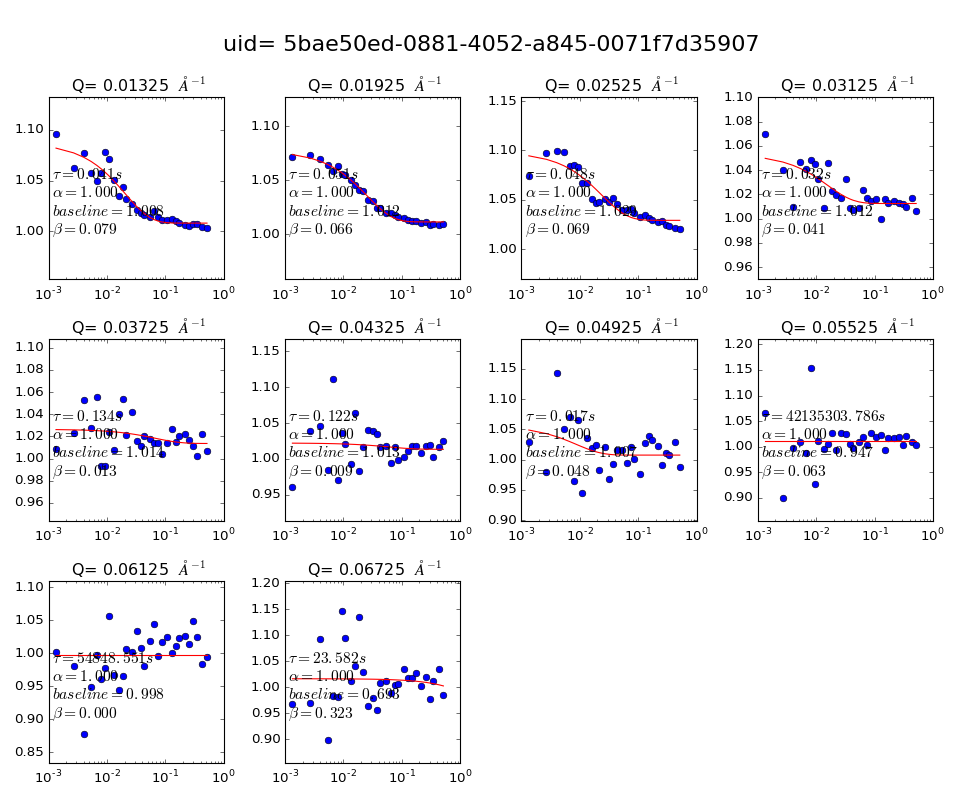

The fitted diffusion coefficient D0 is:  3.904e+03   A^2S-1


<IPython.core.display.Javascript object>


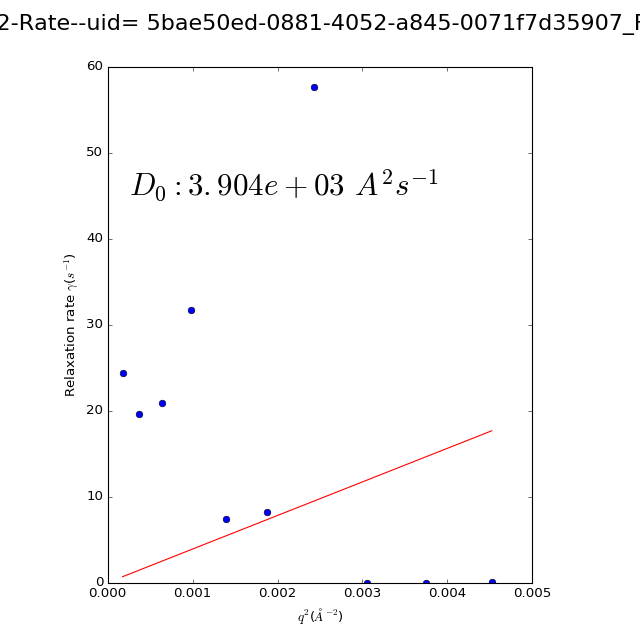

****************************************



In [149]:
g2s, taus, useful_uids  = multi_uids_saxs_xpcs_analysis(   uids, md, run_num, sub_num, 
                                    fit= True, force_compress=False,  compress=True  )


## Create PDF report for each uid

In [152]:
useful_uids

{1: {1: 'c54b9ad8-1d3c-43a8-ae79-60faaac47b38',
  2: 'a2e606fa-22c0-4874-897c-90bd9df57778',
  3: 'e91391ad-8198-406f-8b69-140ef40d4f36',
  4: '4a4770c8-5814-44a5-8c2c-c0f011c676da',
  5: '47b0a91a-e558-439c-8d20-1c01676e7bab',
  6: '4690a7d2-9e2f-431b-97f7-f1e509ef4fcf',
  7: 'a82de589-484b-4c39-b917-c2e926d8736a',
  8: '5bae50ed-0881-4052-a845-0071f7d35907'}}

In [155]:
%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/Create_Report.py

* Create multi PDF report for each uid

In [158]:
create_multi_pdf_reports_for_uids( useful_uids, g2s, data_dir, append_name='_2' )


****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/Dursch/Results/MKSAG_20-T=50C-Nov3-8scan/XPCS_Analysis_Report_for_uid=c54b9ad8-1d3c-43a8-ae79-60faaac47b38_2.pdf
****************************************

****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/Dursch/Results/MKSAG_20-T=50C-Nov3-8scan/XPCS_Analysis_Report_for_uid=a2e606fa-22c0-4874-897c-90bd9df57778_2.pdf
****************************************

****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/Dursch/Results/MKSAG_20-T=50C-Nov3-8scan/XPCS_Analysis_Report_for_uid=e91391ad-8198-406f-8b69-140ef40d4f36_2.pdf
****************************************

****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/Dursch/Results/MKSAG_20-T=50C-Nov3-8scan/XPCS_Analysis_Report_for_uid=4a4770c8-5814-44a5-8c2c-c0f0

### Attach each g2 result to the corresponding olog entry

In [159]:
os.environ['HTTPS_PROXY'] = 'https://proxy:8888'
os.environ['no_proxy'] = 'cs.nsls2.local,localhost,127.0.0.1'

In [160]:
from chxanalys.chx_olog import LogEntry,Attachment, update_olog_uid, update_olog_id

In [163]:
for key in list( useful_uids.keys()):
    for k in list( useful_uids[key]):
        uid_k = useful_uids[key][k]
        filename = data_dir + 'XPCS_Analysis_Report_for_uid=%s_2.pdf'%uid_k 
        atch=[  Attachment(open(filename, 'rb')) ] 
        update_olog_uid( uid=uid_k, text='Add XPCS Analysis PDF Report', attachments= atch )
     
    

## Create one PDF including all uids

In [165]:
create_one_pdf_reports_for_uids( useful_uids, g2s, data_dir, filename=uid_ )


****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/Dursch/Results/MKSAG_20-T=50C-Nov3-8scan/XPCS_Analysis_Report_for_uid=MKSAG_20-T=50C-Nov3-8scan.pdf
****************************************


# Do average Here

In [166]:
list( g2s[1].keys() )

[1, 2, 3, 4, 5, 6, 7, 8]

In [167]:
bad_uids =[  ]

In [168]:
g2s_average ={} # g2s[run] = g2 of each time series average

for key in list( g2s.keys()):
    g2s_average[key] = np.zeros_like( g2s[key][1])
    i=1
    for sub_key in list( g2s[key].keys() ):
        #print (g2s_average[key].shape, g2s[key][sub_key].shape  )        
        try:
            if sub_key not in bad_uids:
                g2s_average[key] +=  g2s[key][sub_key]
                i +=1
                print( 'Run= %s--sub_run= %s-- pass'%(key, sub_key) )
                #print( 'sub= %s,Doing average here'%sub_key)
            else:
                print( 'sub= %s,Can not Doing average here'%sub_key)
                
        except:            
            print( 'sub= %s,Can not Doing average here'%sub_key)
            pass
    g2s_average[key] /= i-1

Run= 1--sub_run= 1-- pass
Run= 1--sub_run= 2-- pass
Run= 1--sub_run= 3-- pass
Run= 1--sub_run= 4-- pass
Run= 1--sub_run= 5-- pass
Run= 1--sub_run= 6-- pass
Run= 1--sub_run= 7-- pass
Run= 1--sub_run= 8-- pass


# Save Data

In [169]:
for key in list( g2s.keys()):
    res_pargs = dict(taus=taus, q_ring_center=q_ring_center,
                  path=data_dir_, uid=  uid_ + '@run--%s'%key )
    save_saxs_g2(    g2s_average[key], res_pargs )


The correlation function is saved in /XF11ID/analysis/2016_3/Dursch/Results/MKSAG_20-T=50C-Nov3-8scan/Average/ with filename as uid=MKSAG_20-T=50C-Nov3-8scan@run--1--g2.csv


# Plot All the g2 Data

In [170]:
if False:
    for key in list( g2s.keys()):
        for sub_key in  list( g2s[key].keys()):
            res_pargs = dict(taus=taus, q_ring_center=q_ring_center,
                          path=data_dir_, uid=  uid_ + '@run--%s--subrun--%s'%(key, sub_key) )
            plot_saxs_g2( g2s[key][sub_key], taus,  vlim=[0.95, 1.05], res_pargs=res_pargs) 


# Plot Avergaed Data

In [171]:
if False:
    for key in list( g2s.keys()):
        res_pargs = dict(taus=taus, q_ring_center=q_ring_center,
                          path=data_dir_, uid=  uid_ + '@run--%s'%key )
        plot_saxs_g2( g2s_average[key], taus,  vlim=[0.95, 1.05], res_pargs=res_pargs) 

# Fit Averaged Data

In [172]:
fit = True

<IPython.core.display.Javascript object>


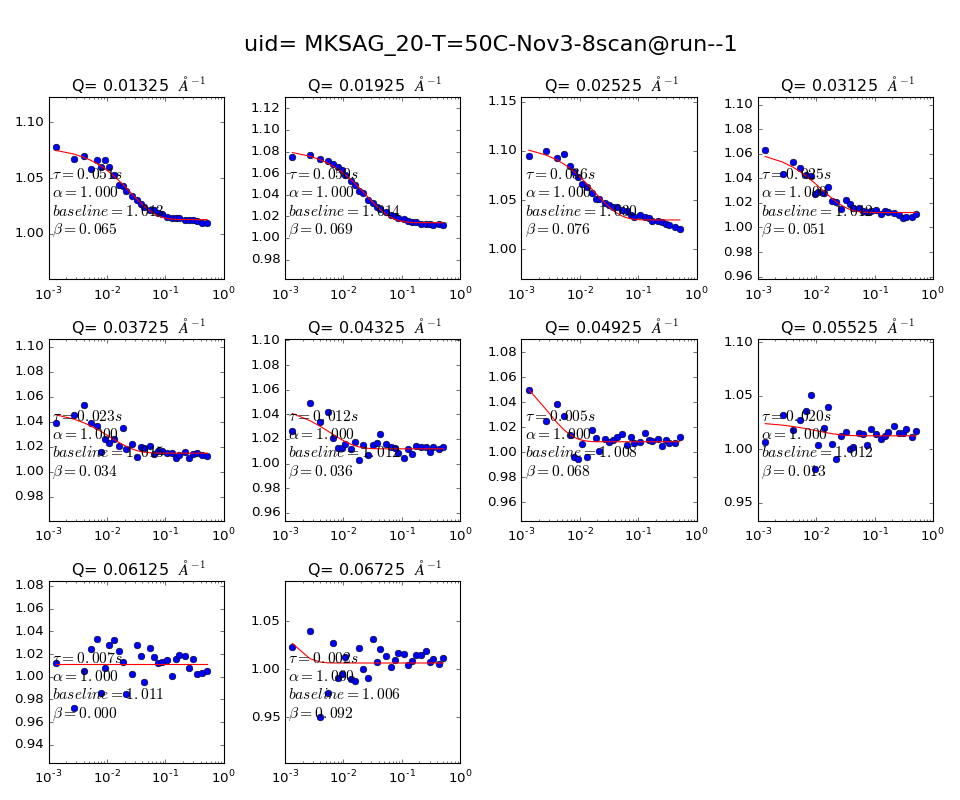

The fitted diffusion coefficient D0 is:  7.057e+04   A^2S-1


<IPython.core.display.Javascript object>


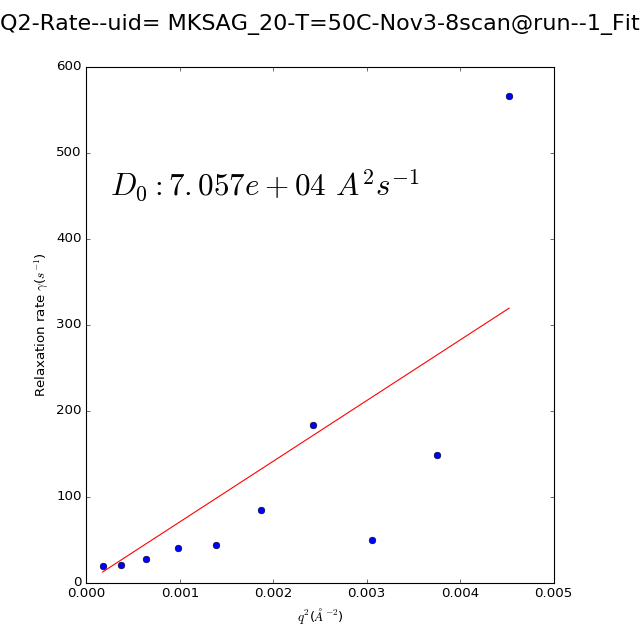

In [174]:
if fit:

    for key in list( g2s.keys()):
        res_pargs = dict(taus=taus, q_ring_center=q_ring_center,
                      path=data_dir_, uid=  uid_ + '@run--%s'%key )

        fit_result = fit_saxs_g2( g2s_average[key], res_pargs, function = 'stretched',  vlim=[0.95, 1.05], 
                    fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},
                    guess_values={'baseline':1.45,'beta':0.08,'alpha':1.0,'relaxation_rate':0.01})
        
        #psave_obj( fit_result, data_dir + uid_ + '@run--%s'%key )
        
        fit_q_rate(  q_ring_center, fit_result['rate'], power_variable= False,
           uid=uid_ + '@run--%s'%key, path= data_dir_ )

        save_lists( [q_ring_center**2,fit_result['rate']], ['q2','rate'], 
                   filename= 'Q2-rate-uid=%s'%(uid_ + '@run--%s'%key), path= data_dir)

# Create a report for the avergae g2

In [175]:
create_report = True

In [176]:
#data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')

In [177]:
pdf_out_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')
filename= "XPCS_Analysis_Report_for_uid=%s-average.pdf"%uid_
print (pdf_out_dir + filename)

/XF11ID/analysis/2016_3/Dursch/Results/XPCS_Analysis_Report_for_uid=MKSAG_20-T=50C-Nov3-8scan-average.pdf


In [178]:
uid_

'MKSAG_20-T=50C-Nov3-8scan'

In [179]:
if create_report:
    
    c= create_pdf_report(  data_dir_, uid_, pdf_out_dir,
                        filename= filename)
    page =1
    #Page one: Meta-data/Iq-Q/ROI
    c.report_header(page=page)
    c.report_meta( top=730)
    c.report_static( top=560)
    c.report_ROI( top= 300)
    Nk = len( list( g2s.keys()))
    Npages = Nk//2 + Nk%2
    
    for i, key in enumerate( list( g2s.keys())):        
        if not i%2:
            page += 1
            c.new_page()            
        
        c.report_header(page=page)
        if i%2:
            top = 350
        else:
            top = 720
            
        c.report_one_time( top= top, g2_fit_file =  'uid=%s@run--%s--g2--fit-.png'%(uid_,key  ),                     
                                 q_rate_file =  'uid=%s@run--%s--Q-Rate--fit-.png'%(uid_,key  ))
        
    c.save_page()
    c.done()  


****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_3/Dursch/Results/XPCS_Analysis_Report_for_uid=MKSAG_20-T=50C-Nov3-8scan-average.pdf
****************************************


# The End!

In [180]:
last_uid_num = len( useful_uids[1] )

In [185]:
uid_last = useful_uids[1][    last_uid_num     ]
print( uid_last )

5bae50ed-0881-4052-a845-0071f7d35907


In [182]:
#uid_last = useful_uids[1][-1]

In [183]:
c.filename

'/XF11ID/analysis/2016_3/Dursch/Results/XPCS_Analysis_Report_for_uid=MKSAG_20-T=50C-Nov3-8scan-average.pdf'

In [184]:
#uid_ = uid_last  #useful_uids[key][k]
filename = c.filename  #XPCS_Analysis_Report_for_uid=%s.pdf'%uid_ 
atch=[  Attachment(open(filename, 'rb')) ] 
update_olog_uid( uid=uid_last, text='Add XPCS Analysis PDF Report', attachments= atch )